# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Створюємо об'єкт метрики точності
    acc = tf.metrics.Accuracy()

    # Оновлюємо стан метрики з урахуванням передбачених та дійсних міток
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))

    # Отримуємо поточне значення точності
    return acc.result()

In [11]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Обчислюємо точність на основі поточних передбачень
    acc = accuracy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, acc

In [12]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    #train(neural_net, batch_x, batch_y)
    current_loss, current_accuracy = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Обчислюємо функцію втрат на поточному кроці
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)

        # Додаємо точність на поточному етапі в історію
        accuracy_history.append(current_accuracy)

        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 100, Loss: 590.9707641601562, Accuracy: 0.0859375
Step: 200, Loss: 591.4696044921875, Accuracy: 0.08203125
Step: 300, Loss: 589.9097290039062, Accuracy: 0.09765625
Step: 400, Loss: 590.2630004882812, Accuracy: 0.10546875
Step: 500, Loss: 583.88818359375, Accuracy: 0.1953125
Step: 600, Loss: 585.6231689453125, Accuracy: 0.171875
Step: 700, Loss: 582.1412353515625, Accuracy: 0.18359375
Step: 800, Loss: 581.3076171875, Accuracy: 0.1953125
Step: 900, Loss: 574.9631958007812, Accuracy: 0.2421875
Step: 1000, Loss: 567.2490844726562, Accuracy: 0.2421875
Step: 1100, Loss: 537.7836303710938, Accuracy: 0.30078125
Step: 1200, Loss: 534.3359985351562, Accuracy: 0.27734375
Step: 1300, Loss: 526.7770385742188, Accuracy: 0.3046875
Step: 1400, Loss: 520.983154296875, Accuracy: 0.3125
Step: 1500, Loss: 501.40960693359375, Accuracy: 0.296875
Step: 1600, Loss: 494.9671630859375, Accuracy: 0.328125
Step: 1700, Loss: 461.6546325683594, Accuracy: 0.3203125
Step: 1800, Loss: 427.26861572265625, Accurac

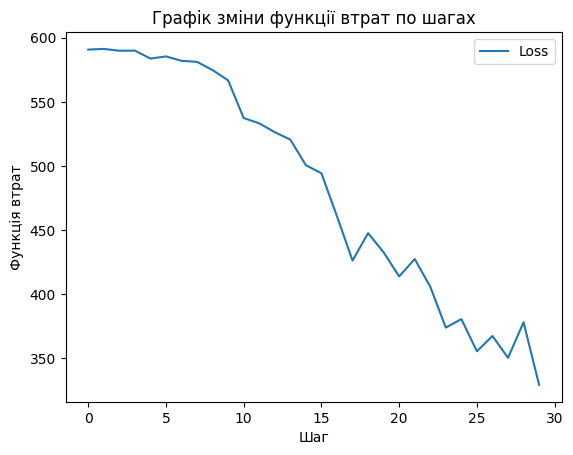

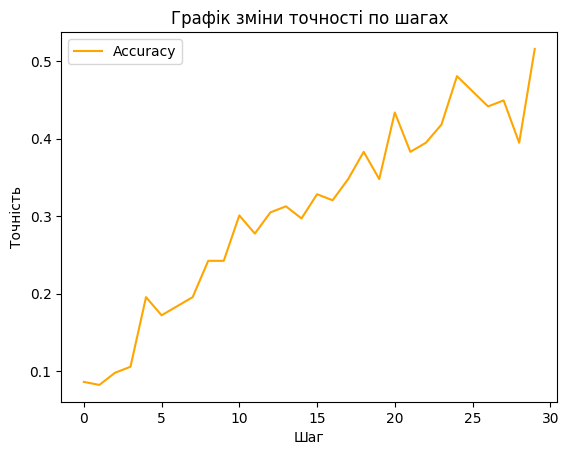

In [13]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Loss')
plt.xlabel('Шаг')
plt.ylabel('Функція втрат')
plt.title('Графік зміни функції втрат по шагах')
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Accuracy', color='orange')
plt.xlabel('Шаг')
plt.ylabel('Точність')
plt.title('Графік зміни точності по шагах')
plt.legend()
plt.show()

In [14]:
# Обчисліть точність навченої нейромережі
neural_net_accuracy_train = accuracy(neural_net(x_train), y_train)
print(f"Точність на тренувальних даних: {neural_net_accuracy_train}")

# Тестування моделі на тестових даних
neural_net_accuracy_test = accuracy(neural_net(x_test), y_test)
print(f"Точність на тестових даних: {neural_net_accuracy_test}")

Точність на тренувальних даних: 0.4643999934196472
Точність на тестових даних: 0.4595000147819519


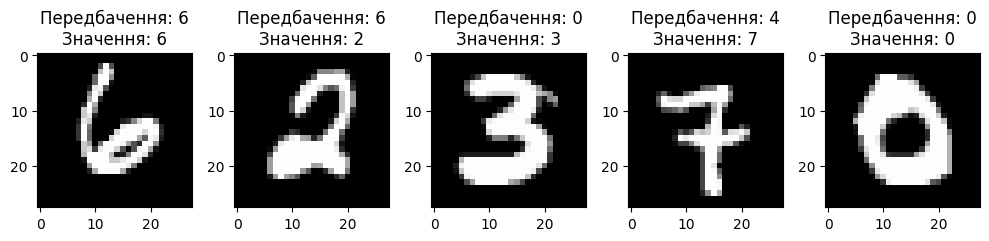

In [23]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# вибираємо 5 випадкових індексів для тестування
test_indices = np.random.choice(len(x_test), 5, replace=False)

plt.figure(figsize=(10, 5))

for i, idx in enumerate(test_indices, 1):
    img = x_test[idx].reshape((28, 28))
    # Передбачаємо клас для вибраного зображення
    pred = np.argmax(neural_net(x_test[idx:idx+1]))
    # Істинний клас
    true_label = y_test[idx]

    plt.subplot(2, 5, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"Передбачення: {pred}\nЗначення: {true_label}")

plt.tight_layout()
plt.show()


